### Nuclear norm minimization vs. IHT for low-rank matrices

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import math
import matplotlib.pyplot as plt
from bokeh.plotting import figure, show, output_file
from bokeh.palettes import brewer

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.cm as cm

import random
from numpy import linalg as la

from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
rc('font',**{'family':'serif','serif':['Palatino']})
rc('text', usetex=True)

p = 128  # Matrices of size p x p
r = 2   # low rank level
n = np.ceil(5 * p * r)

# Generate a pxp-dimensional zero matrix
A = np.random.randn(p, r)
B = np.random.randn(p, r)
X_star = A.dot(B.T)
X_star = (1 / la.norm(X_star, 'fro')) * X_star

# Generate matrices for the sensing mechanism
A = np.zeros((int(n), p, p))
for i in range(int(n)):
    C = (1/np.sqrt(n)) * np.random.randn(p, p)
    A[i, :, :] = C

# print(A[1, :, :])
# print(np.squeeze(A[i, :, :]))
# print(np.squeeze(A[i, :, :]).shape)
# print(1/np.sqrt(n))
# Observation model
y = np.zeros(int(n))

for i in range(int(n)):
    B = np.squeeze(A[i, :, :])
    y[i] = np.trace(B.dot(X_star.T))

In [2]:
from scipy.sparse.linalg import svds, eigs

# Hard thresholding function
def hardThreshold(X, r):
    U, S, V = svds(X, k = r)    
    S = np.diag(S)
    return U.dot(S.dot(V))

def l1normProj(x, l):
    assert l > 0, "Radius lambda must be strictly positive (%d <= 0)" % l
    n, = x.shape  
    
    u = np.abs(x)                               # compute the vector of absolute values
    
    if u.sum() <= l:                            # check if v is already a solution    
        return x
    
    u = np.sort(x)[::-1]                        # get the array of cumulative sums of a sorted (decreasing) copy of v
    cssv = np.cumsum(u)
    rho = np.nonzero(u * np.arange(1, n+1) > (cssv - l))[0][-1]   # get the number of > 0 components of the optimal solution
    theta = (float(cssv[rho] - l) / rho).clip(min=0)                 # compute the projection by thresholding v using theta          # compute the Lagrange multiplier associated to the simplex constraint
    w = (np.abs(x) - theta).clip(min=0)                 # compute the projection by thresholding v using theta
    w *= np.sign(x)    
        
    return w

def proj_nuclear_norm(X, l):
    U, S, V = la.svd(X)
    S = l1normProj(S, l)
    S = np.diag(S)
    return U.dot(S.dot(V))
    
# Returns the value of the objecive function
def f(y, A, X):
    f_value = 0
    n = y.shape[0]
    for i in range(n):
        B = np.squeeze(A[i, :, :])
        f_value += 0.5 * (y[i] - np.trace(B.dot(X.T)))**2
    return f_value

def compute_grad(y, A, X):
    n = y.shape[0]
    p = A.shape[1]

    grad = np.zeros((p, p))
    b = np.zeros(n)
    
    for i in range(n):
        B = np.squeeze(A[i, :, :])        
        b[i] = y[i] - np.trace(B.dot(X.T))
    
#     print(b)
    for i in range(n):
        B = np.squeeze(A[i, :, :])
        grad += -b[i] * B;
    
#     print(grad)
    return grad

def matrix_IHT(y, A, r, eta, iters, epsilon, verbose, X_star):
    # Length of original signal
    p = A.shape[1]
    # Length of measurement vector
    n = A.shape[0]

    # Initial estimate
    X_new = np.zeros((p, p))
    
    X_list, f_list = [1], [f(y, A, X_new)]

    for i in range(iters):
        X_old = X_new
    
        # Compute gradient
        grad = compute_grad(y, A, X_old)
#         print(grad)
        # Perform gradient step
        X_temp = X_old - eta * grad    
    
        # Perform hard thresholding step
        X_new = hardThreshold(X_temp, r)
    
        if (la.norm(X_new - X_old, 'fro') / la.norm(X_new, 'fro')) < epsilon:
            break
                
        # Keep track of solutions and objective values
        X_list.append(la.norm(X_new - X_star, 'fro'))
        f_list.append(f(y, A, X_new))
        
        if verbose:
            print("iter# = "+ str(i) + ", ||X_new - X_old||_2 = " + str(la.norm(X_new - X_old, 'fro') / la.norm(X_new, 'fro')))
    
    print("Number of steps:", len(f_list))
    return X_new, X_list, f_list

def matrix_nuclear_norm_min(y, A, l, eta, iters, epsilon, verbose, X_star):
    # Length of original signal
    p = A.shape[1]
    # Length of measurement vector
    n = A.shape[0]

    # Initial estimate
    X_new = np.zeros((p, p))
    
    X_list, f_list = [1], [f(y, A, X_new)]

    for i in range(iters):
        X_old = X_new
    
        # Compute gradient
        grad = compute_grad(y, A, X_old)
    
        # Perform gradient step
        X_temp = X_old - eta * grad    
    
        # Perform hard thresholding step
        X_new = proj_nuclear_norm(X_temp, l)
    
        if (la.norm(X_new - X_old, 'fro') / la.norm(X_new, 'fro')) < epsilon:
            break
                
        # Keep track of solutions and objective values
        X_list.append(la.norm(X_new - X_star, 'fro'))
        f_list.append(f(y, A, X_new))
        
        if verbose:
            print("iter# = "+ str(i) + ", ||X_new - X_old||_2 = " + str(la.norm(X_new - X_old, 'fro') / la.norm(X_new, 'fro')))
    
    print("Number of steps:", len(f_list))
    return X_new, X_list, f_list

iter# = 0, ||X_new - X_old||_2 = 1.0
iter# = 1, ||X_new - X_old||_2 = 0.4539310614839091
iter# = 2, ||X_new - X_old||_2 = 0.27632978515380846
iter# = 3, ||X_new - X_old||_2 = 0.19042157223340067
iter# = 4, ||X_new - X_old||_2 = 0.1408649175075586
iter# = 5, ||X_new - X_old||_2 = 0.10923259182400315
iter# = 6, ||X_new - X_old||_2 = 0.08764928644575458
iter# = 7, ||X_new - X_old||_2 = 0.07219881897240481
iter# = 8, ||X_new - X_old||_2 = 0.06072484526593615
iter# = 9, ||X_new - X_old||_2 = 0.051950008893183866
iter# = 10, ||X_new - X_old||_2 = 0.045074904827663936
iter# = 11, ||X_new - X_old||_2 = 0.0395772766028178
iter# = 12, ||X_new - X_old||_2 = 0.03510384598691013
iter# = 13, ||X_new - X_old||_2 = 0.031408589961035994
iter# = 14, ||X_new - X_old||_2 = 0.028315855413469117
iter# = 15, ||X_new - X_old||_2 = 0.025697468009438364
iter# = 16, ||X_new - X_old||_2 = 0.023458071290856655
iter# = 17, ||X_new - X_old||_2 = 0.021525481828082442
iter# = 18, ||X_new - X_old||_2 = 0.01984419477470

iter# = 42, ||X_new - X_old||_2 = 0.009370049350073505
iter# = 43, ||X_new - X_old||_2 = 0.009150093786700864
iter# = 44, ||X_new - X_old||_2 = 0.00893865250461487
iter# = 45, ||X_new - X_old||_2 = 0.008697090783858163
iter# = 46, ||X_new - X_old||_2 = 0.0084995773327213
iter# = 47, ||X_new - X_old||_2 = 0.00831216693508949
iter# = 48, ||X_new - X_old||_2 = 0.008132272839460747
iter# = 49, ||X_new - X_old||_2 = 0.007959020190575304
iter# = 50, ||X_new - X_old||_2 = 0.007791923419984519
iter# = 51, ||X_new - X_old||_2 = 0.0076306269093454025
iter# = 52, ||X_new - X_old||_2 = 0.007474833309679991
iter# = 53, ||X_new - X_old||_2 = 0.007324279199067172
iter# = 54, ||X_new - X_old||_2 = 0.007178724537518881
iter# = 55, ||X_new - X_old||_2 = 0.0070379471541339575
iter# = 56, ||X_new - X_old||_2 = 0.006901739390127149
iter# = 57, ||X_new - X_old||_2 = 0.006769905793801642
iter# = 58, ||X_new - X_old||_2 = 0.006642261370549708
iter# = 59, ||X_new - X_old||_2 = 0.006513420156386552
iter# = 60, 

iter# = 189, ||X_new - X_old||_2 = 0.0015639846099262512
iter# = 190, ||X_new - X_old||_2 = 0.0015533152162466948
iter# = 191, ||X_new - X_old||_2 = 0.0015427710419151077
iter# = 192, ||X_new - X_old||_2 = 0.0015323498898218199
iter# = 193, ||X_new - X_old||_2 = 0.0015220496179746531
iter# = 194, ||X_new - X_old||_2 = 0.0015118681382019685
iter# = 195, ||X_new - X_old||_2 = 0.00150180341476302
iter# = 196, ||X_new - X_old||_2 = 0.0014918534628807771
iter# = 197, ||X_new - X_old||_2 = 0.0014820163472225084
iter# = 198, ||X_new - X_old||_2 = 0.0014721502767769904
iter# = 199, ||X_new - X_old||_2 = 0.0014618047851766758
iter# = 200, ||X_new - X_old||_2 = 0.0014517641741706613
iter# = 201, ||X_new - X_old||_2 = 0.001442272008450373
iter# = 202, ||X_new - X_old||_2 = 0.0014329435906659737
iter# = 203, ||X_new - X_old||_2 = 0.0014237386458474724
iter# = 204, ||X_new - X_old||_2 = 0.0014146457569035357
iter# = 205, ||X_new - X_old||_2 = 0.00140565890588176
iter# = 206, ||X_new - X_old||_2 = 0

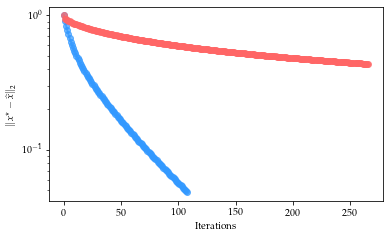

In [3]:
##### Run algorithm
epsilon = 1e-3                # Precision parameter
iters = 1000
eta = 0.1

U, S, V = la.svd(X_star)
l = np.sum(S)

X_IHT, X_list_IHT, f_list_IHT = matrix_IHT(y, A, r, eta, iters, epsilon, True, X_star)
X_NN, X_list_NN, f_list_NN = matrix_nuclear_norm_min(y, A, l, eta, iters, epsilon, True, X_star)

# Plot
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

xs_IHT = range(len(X_list_IHT))
xs_NN = range(len(X_list_NN))

plt.plot(xs_IHT, X_list_IHT, '-o', color = '#3399FF', linewidth = 2, alpha = 0.7) # Blue
plt.plot(xs_NN, X_list_NN, '-o', color = '#FF6666', linewidth = 2, alpha = 0.7) # Red
plt.yscale('log')
plt.xlabel('Iterations')
plt.ylabel(r"$\|x^\star - \widehat{x}\|_2$")

# Make room for the ridiculously large title.
plt.subplots_adjust(top=0.8)
plt.show()